# Binary Classifier on Single records

### Most basic example.
This notebook will show how to set-up learning features (i.e. fields we want to use for modeling), read them from a CSV file. Then create a very simple feed-forward Neural Net to classify fraud vs. non-fraud, train the model and test it.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object. The DataFrame can be used for basic data analysis

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2020-11-12 14:08:45.525 d373c7.engines.common          INFO     Start Engine...
2020-11-12 14:08:45.526 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-12 14:08:45.526 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-12 14:08:45.526 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-11-12 14:08:45.746 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-11-12 14:08:45.752 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)


,age,gender,merchant,category,amount,fraud
0,4,M,M348934600,es_transportation,4.55,0
1,2,M,M348934600,es_transportation,39.68,0
2,4,F,M1823072687,es_transportation,26.89,0
3,3,M,M348934600,es_transportation,17.25,0
4,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...
594638,3,F,M1823072687,es_transportation,20.53,0
594639,4,F,M1823072687,es_transportation,50.73,0
594640,2,F,M349281107,es_fashion,22.44,0
594641,5,M,M1823072687,es_transportation,14.46,0


## Define some derived features
After we've defined and read the base features, we can define some __derived__ features. Derived features apply a form of transformation to the base features. The transformation depends on the type of feature. The derived features can be created using the `EnginePandasNumpy` using the `from_df` method. 
The `from_df` takes the previously created DataFrame as input + a set of derived features and returns a Pandas DataFrame with the derived features

In this example 2 transformations are used;
- The amount is scaled between 0 and 1.
- The categorical features are turned into one-hot encoded fields. 

We apply above transformations because Neural Nets prefer data that is in Binary ranges 0->1 or normally distributed

This will create a total of 78 features we can use in the model (-the fraud)

In [5]:
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_scale,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_df(learning_features, df, inference=False)
df

2020-11-12 14:10:02.837 d373c7.engines.common          INFO     Start Engine...
2020-11-12 14:10:02.838 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-12 14:10:02.838 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-12 14:10:02.838 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-11-12 14:10:02.927 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2020-11-12 14:10:02.969 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 79)


,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,gender__E,gender__F,...,category__es_hyper,category__es_leisure,category__es_otherservices,category__es_sportsandtoys,category__es_tech,category__es_transportation,category__es_travel,category__es_wellnessandbeauty,amount_scale,fraud_label
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.000546,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.004764,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.003228,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.002071,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.004288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.002465,0
594639,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.006090,0
594640,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.002694,0
594641,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.001736,0


## Convert to Numpy

Now we convert the panda DataFrame to a list of Numpy arrays (which can be used for training). The `NumpyList` will have an entry for each of the Learning types. It will split out the Binary, Continuous, Categorical and Label Learning type __features__. Each Learning type will have a list entry in the `NumpyList` object

This step is needed so the models understand how to use the features in the learning and testing processes. 

In this case we have a first list with 77 binary (one-hot-endoded) features, the second is a list with 1 continuous feature (the amount) and the last list is the label (Fraud or Non-Fraud).

In [6]:
with en.EnginePandasNumpy() as e:
    data_list = e.to_numpy_list(learning_features, df)
print(data_list.shapes)
print(data_list.dtype_names)

2020-11-12 14:11:08.838 d373c7.engines.common          INFO     Start Engine...
2020-11-12 14:11:08.838 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-12 14:11:08.838 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-12 14:11:08.839 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-11-12 14:11:08.839 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2020-11-12 14:11:08.862 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2020-11-12 14:11:08.862 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2020-11-12 14:11:08.864 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-11-12 14:11:08.864 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 77), (594643,), (594643,)]
['int8', 'float32', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.



In [7]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(464643, 77), (464643,), (464643,)]
Validation Data shapes [(30000, 77), (30000,), (30000,)]
Test Data shapes [(100000, 77), (100000,), (100000,)]
Done


## Set-up device

In [8]:
device, cpu = pt.init_devices()

2020-11-12 14:11:25.685 d373c7.pytorch.common          INFO     Torch Version : 1.6.0
2020-11-12 14:11:25.772 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-11-12 14:11:25.772 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


# Define Model


The training data set has to be balanced for Neural Nets. A balanced data set has a more or less equal amount of each class of the label. In our case fraud vs. non-fraud classes. Failing to balance the data can have dramatic results, Neural Nets are lazy, in extreme cases they might just plain always predict the majority class.

In this example the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label. This may not be a good idea for a really large data sets.

> 1. First set-up a NumpyListDataSet for both the training data-set and validation data-set. A NumpyListDataSet is a specialized `Pytorch Dataset` which keeps the data as numpy arrays in memory and converts on the fly to `Pytorch Tensors`
> 2. Set-up a sampler for the training set only. The sampler will over-sample the '1'/fraud class. Note that this means the training and validation sets are balanced *differently*. This is important when interpreting the plots.
> 3. Wrap the dataset in a Pytorch Dataloader. `Dataloaders` allow the training loop to iterate over `Datasets`
> 4. Create a model. Here the most basic __FeedforwardFraudClassifier__ is used. A __FeedforwardFraudClassifier__ takes a TensorDefinition as input, runs it through a series of Linear layers. *We are defining it to have 1 hidden layer of size 16*. The last layer is a single number, it had a sigmoid applied to it so we can more or less interpret this as a 'probability of fraud'. We use Binary Crossentropy loss. 


In [10]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)
train_sampler = pt.ClassSampler(learning_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.FeedForwardFraudClassifier(learning_features, layers=[16])
print(m)

FeedForwardFraudClassifier(
  Number of parameters : 1313
  (head): TensorDefinitionHead(lcs=['Binary', 'Continuous'])
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linear(in_features=78, out_features=16, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU(inplace=True)
    )
  )
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): SingleClassBinaryOutput(
    (out_block): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)


Grapically this network looks like below (Some of the layers have been omitted for simplicity)

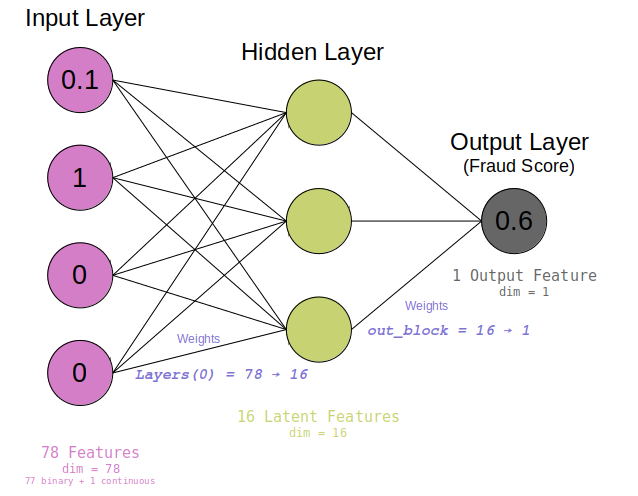

# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr funtion and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate. It tends to show where we can find a good learning rate. In this case at around __5e-3__ we start a very steep decent. The model does not learn at lower than __10e-3__. Beyond 10e-2 it flattens out and explodes later. This can be validate by running with a higher number of iteration and higher upper bound. A good learning rate is a location where the curve starts descending. In this case around __5e-3__

2020-11-12 14:16:30.439 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 429.55it/s]
2020-11-12 14:16:32.769 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


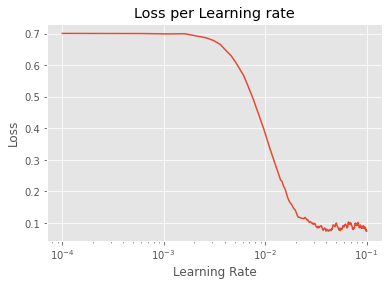

In [11]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times where the model learns, after that we use the trained model and perform a run on the validation set.

> The result graph plots the accuracy and loss evolution at each Epoch for both the training and the validation set. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate. 

Epoch 010/010: 100%|██████████| 3866/3866 [00:06<00:00, 636.06it/s, train_loss=0.0557, train_acc=0.978, val_loss=0.036, val_acc=0.982]


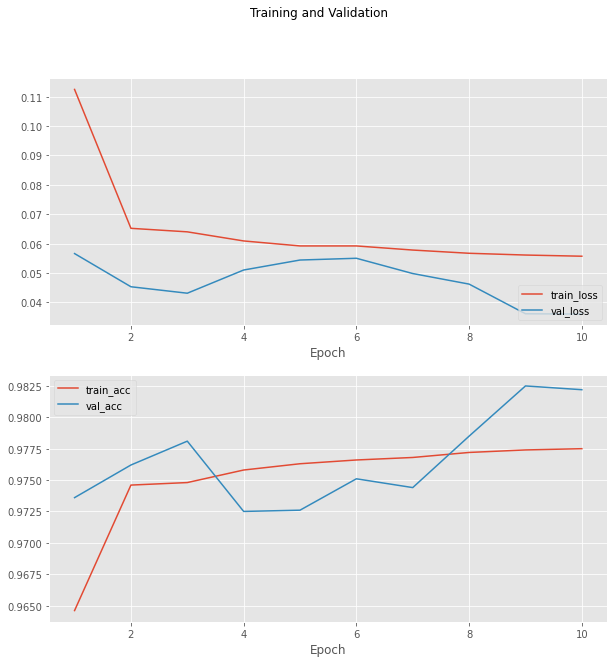

In [12]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. This model behaves fairly OK. It is really good at catching the fraud. It has a fairly low False Negative rate. (Lower left corner of the Confusion Matrix). But it also has a fairly large False Positive rate (Upper right corner of the Confusion Matrix).
Some research would be needed but this is likely at least partially due to the oversampling. The model saw much more fraud during the training, so it might not be surprising it gets relatively good at predicting it.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 801.28it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.41      0.98      0.58      1074

    accuracy                           0.98    100000
   macro avg       0.71      0.98      0.79    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9987
ap score  : 0.9272
-----------------------------------------------------


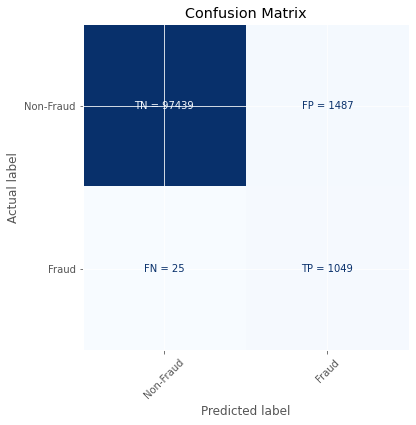

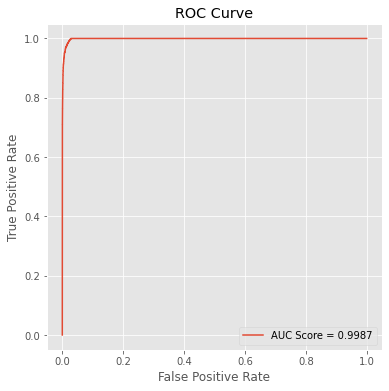

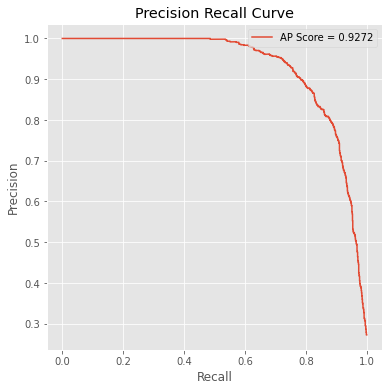

In [13]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conslusion
This is a first example that showed how we can read a file, set-up some features (fields), test and train a really simple Feed-Forward Neural Net model.